In [1]:


import os
from datetime import datetime
import torch

#  To save the model for later use (saves in incrementing order at the ./models directory)
def save_model(model,name_postfix="", directory="./models", modelcount_file="modelcount.txt"):
    """
    Save a PyTorch model with an auto-incremented name and timestamp.

    This function saves the given PyTorch model's state dictionary to a specified directory.
    It maintains a model count using a file (`modelcount.txt`) to ensure unique model naming.
    The saved model filename follows the format: `model_<count>_<name_postfix>_<timestamp>.pth`.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        name_postfix (str, optional): A custom postfix to append to the model filename. Default is an empty string.
        directory (str, optional): The directory where the model should be saved. Default is `./models`.
        modelcount_file (str, optional): The filename for tracking model count. Default is `modelcount.txt`.

    Returns:
        None: The function saves the model and prints the file path.
    """
    
    os.makedirs(directory, exist_ok=True)
    modelcount_path = os.path.join(directory, modelcount_file)
    
    # Read the current model count
    if os.path.exists(modelcount_path):
        with open(modelcount_path, 'r') as f:
            model_count = int(f.read().strip())
    else:
        model_count = 0  

    # Generate model name
    model_name = f"model_{model_count}"
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_file_path = os.path.join(directory, f"{model_name}_{name_postfix}_{timestamp}.pth")
    
    # Save the model
    torch.save(model.state_dict(), model_file_path)
    print(f"Model saved at: {model_file_path}")
    
    model_count += 1
    with open(modelcount_path, 'w') as f:
        f.write(str(model_count))
        
def load_model(model, load_path="", device="cuda"):
    """
    Load a PyTorch model from a specified file path.

    This function loads the model's state dictionary from a checkpoint file and 
    moves the model to the specified device for inference.

    Args:
        model (torch.nn.Module): The PyTorch model to load weights into.
        load_path (str): The file path to the saved model checkpoint. Must be provided.
        device (str, optional): The device to load the model onto ("cuda" or "cpu"). 
            Default is `"cuda"`.

    Returns:
        torch.nn.Module: The model with loaded weights, ready for inference.

    Raises:
        ValueError: If `load_path` is not provided or is an empty string.
        FileNotFoundError: If the specified `load_path` does not exist.
    """

    if not load_path:
        raise ValueError("Error: No load path provided. Please specify a valid model checkpoint path.")

    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Error: Model file not found at '{load_path}'. Please check the path.")

    model.load_state_dict(torch.load(load_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from: {load_path}")
    
    return model



## Data Parser

Read the given Semeval training dataset into dataframe

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import re


# --- Constants ---
MODEL_NAME = "xlm-roberta-base"  # "xlm-roberta-base" OR bert-base-multilingual-cased
DATA_PATH = "./dataset/training_data"
WINDOW_SIZE = 300  

# Helping Functions

def find_closest_pair(indices, ref_start, ref_end):
    """
    Find the closest pair of indices to a reference range.

    This function takes a list of (start, end) index pairs and finds the pair 
    that has the minimum combined absolute distance from a given reference start 
    and end index.

    Args:
        indices (list of tuples): A list of (start, end) index pairs.
        ref_start (int): The reference start index.
        ref_end (int): The reference end index.

    Returns:
        tuple: The (start, end) index pair that is closest to the reference indices.
               Returns None if the list is empty.
    """
    closest_pair = None
    min_distance = float('inf')  

    for start, end in indices:
        # Calculate the distance to the reference indices
        distance = abs(ref_start - start) + abs(ref_end - end)
        if distance < min_distance:
            min_distance = distance
            closest_pair = (start, end)
    
    return closest_pair


def get_clean_context(text, entity_mention,start, end, window_size):
    """
    Extract context with complete words before and after the entity mention.
    
    Args:
        text (str): Full article text
        start (int): Start offset of entity mention
        end (int): End offset of entity mention
        window_size (int): Approximate number of characters for context window
    
    Returns:
        str: Clean context with complete words
    """

    before_start = max(0, start - window_size)
    if before_start > 0:
        while before_start < start and not text[before_start].isspace():
            before_start += 1

        while before_start > 0 and text[before_start-1].isspace():
            before_start -= 1

    after_end = min(len(text), end + window_size)
    if after_end < len(text):
        while after_end < len(text) and not text[after_end].isspace():
            after_end += 1

    # Extract context
    before_context = text[before_start:start].strip()
    entity = text[start:end+1]
    after_context = text[end+1:after_end].strip()
    
    return f"{before_context} <entity>{entity}</entity> {after_context}"



def load_data(lang_code):
        """
        Load and process annotated data for a given language.

        This function reads annotation labels and corresponding raw text documents for a specified
        language. It extracts entity mentions and their context from articles while handling potential
        mismatches in character offsets.

        Args:
            lang_code (str): The language code (e.g., 'EN', 'PT') corresponding to the dataset.

        Returns:
            pandas.DataFrame: A DataFrame containing the extracted data with the following columns:
                - "entity_mention" (str): The entity mention in the article.
                - "main_role" (str): The main role assigned to the entity.
                - "fine_grained_roles" (list): A list of fine-grained role annotations.
                - "context" (str): A cleaned textual context window surrounding the entity mention.
            mismatch_count (int): The number of mismatches corrected.
            mismatch_diffs (list of tuples): Each tuple contains (diff_start, diff_end)
                representing the absolute difference between the provided and corrected offsets.
        
        Notes:
            - The function reads data from `subtask-1-annotations.txt` and raw text documents stored 
            in `raw-documents/` under the language-specific directory.
            - It ensures that entity offsets in the annotation file match their occurrences in the article.
            - If offsets do not match, the function attempts to find the closest match within the text.
            - Articles missing from the dataset trigger a warning but do not halt execution.
            - The extracted context is cleaned by replacing newline characters with spaces.
        
        Warnings:
            - Prints a warning if an entity mention is not found at the expected position.
            - Prints a warning if an article file is missing.
            - Skips lines with an incorrect number of fields in the annotation file.

        Example:
            >>> df = load_data("EN")
            >>> df.head()
        
        """


        labels_file = os.path.join(DATA_PATH, lang_code, "subtask-1-annotations.txt")
        articles_dir = os.path.join(DATA_PATH, lang_code, "raw-documents")
        data = []
        mismatch_count = 0
        mismatch_diffs = []  # List of tuples (diff_start, diff_end)

        with open(labels_file, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                fields = line.strip().split("\t")
                if len(fields) >= 6:
                    article_id, entity_mention, start_offset, end_offset, main_role, *fine_grained_roles = fields
                    article_path = os.path.join(articles_dir, article_id)
                    try:
                        with open(article_path, "r", encoding="utf-8") as article_file:
                            article_text = article_file.read()

                        provided_start = int(start_offset)
                        provided_end = int(end_offset)
                        start = provided_start
                        end = provided_end

                        # If the provided offsets do not yield the entity_mention, attempt a correction
                        if article_text[start:end+1] != entity_mention:
                            matches = re.finditer(rf'{re.escape(entity_mention)}', article_text)
                            indices = [(match.start(), match.end() - 1) for match in matches]

                            correct_offset = find_closest_pair(indices, start, end)
                            if correct_offset is not None:
                                diff_start = abs(correct_offset[0] - provided_start)
                                diff_end = abs(correct_offset[1] - provided_end)
                                mismatch_diffs.append((diff_start, diff_end))
                                mismatch_count += 1
                                start, end = correct_offset
                            else:
                                print(f"Warning: Entity mention not found in {article_id}")
                                continue

                        context_span = get_clean_context(article_text, entity_mention, start, end, WINDOW_SIZE)
                        context_span = re.sub(r'\n+', ' ', context_span)

                        data.append({
                            "entity_mention": entity_mention,
                            "main_role": main_role,
                            "fine_grained_roles": fine_grained_roles,
                            "context": context_span,
                            "language": lang_code  # Add language info for later visualization
                        })
                    except FileNotFoundError:
                        print(f"Warning: Article file not found for {article_id}")
                else:
                    print(f"Skipping line {line_num} in {labels_file}: Incorrect number of fields ({len(fields)})")

        df = pd.DataFrame(data)
        return df, mismatch_count, mismatch_diffs


# --- Load Data for Both Languages ---
df_en, mismatches_en, mismatch_diffs_en = load_data("EN")
df_pt, mismatches_pt, mismatch_diffs_pt = load_data("PT")
df = pd.concat([df_en, df_pt])
print(df.head().to_string())





/home/user/ehsanullahm1/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  entity_mention    main_role      fine_grained_roles                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     context language
0        Chinese   Antagonist                   [Spy]  States since the beginning of the fiscal year in October. If this rate continues, this year’s total will easily top the 24,125 Chinese nationals who illegally entered the country last year. TRUTH LIVES on at https://sgtreport.tv/ There has been an astounding 6,3

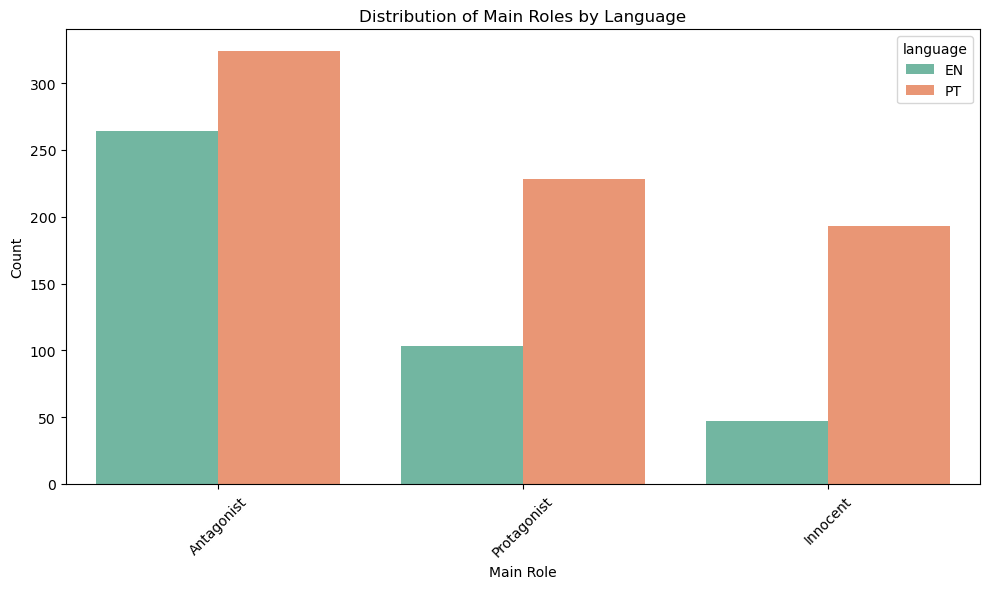

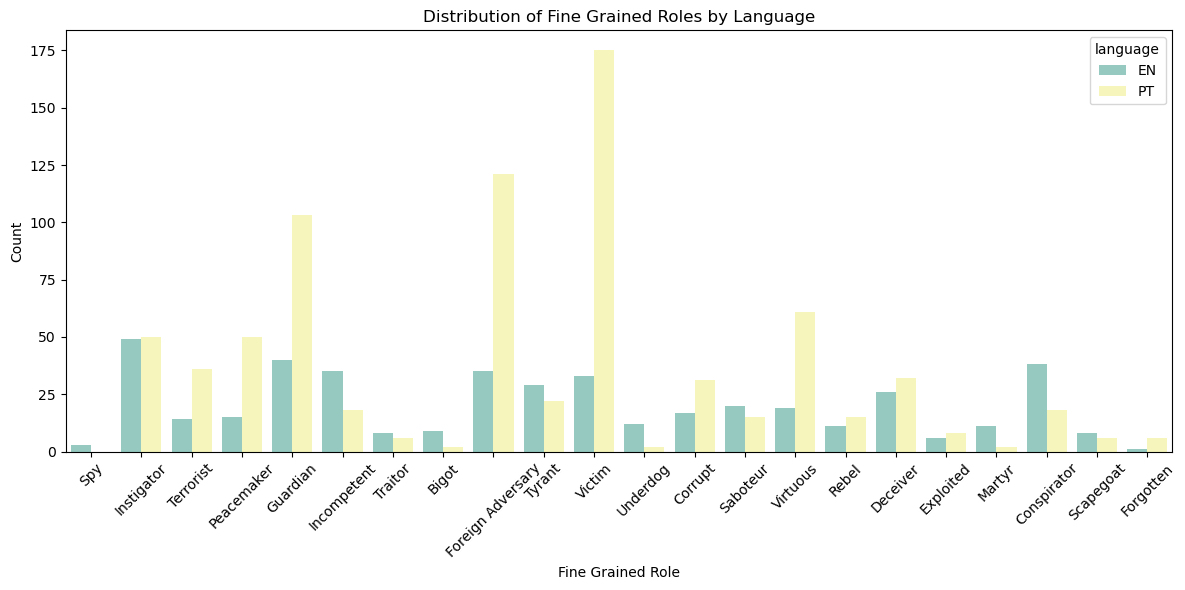

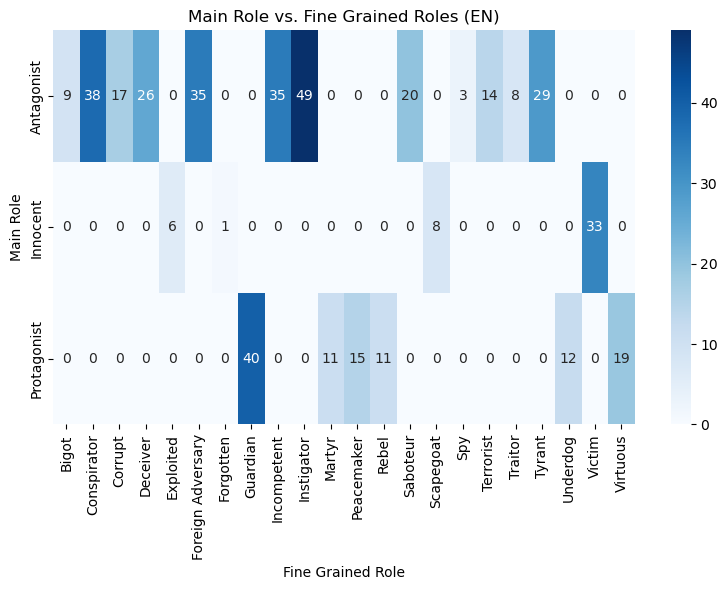

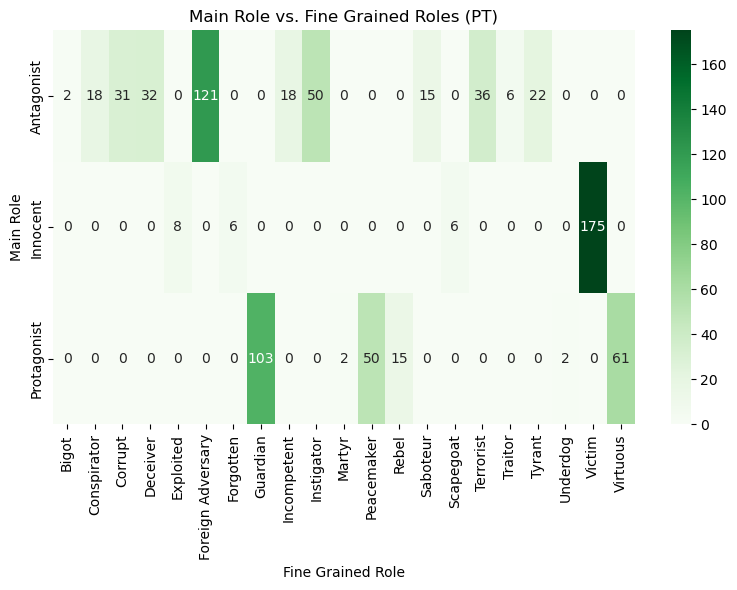

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Role Distribution Visualizations

# (a) Main Role Distribution by Language
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='main_role', hue='language', palette="Set2")
plt.title("Distribution of Main Roles by Language")
plt.xlabel("Main Role")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (b) Fine Grained Roles Distribution by Language
# Since 'fine_grained_roles' is stored as a list, we first explode the column.
df_exploded = df.explode('fine_grained_roles')
plt.figure(figsize=(12, 6))
sns.countplot(data=df_exploded, x='fine_grained_roles', hue='language', palette="Set3")
plt.title("Distribution of Fine Grained Roles by Language")
plt.xlabel("Fine Grained Role")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (c) Heatmap of Main Role vs. Fine Grained Roles for each language
# Explode the 'fine_grained_roles' column and reset the index
df_exploded = df.explode('fine_grained_roles').reset_index(drop=True)

# Create separate crosstabs for each language.
crosstab_en = pd.crosstab(
    df_exploded.loc[df_exploded['language'] == 'EN', 'main_role'],
    df_exploded.loc[df_exploded['language'] == 'EN', 'fine_grained_roles']
)
crosstab_pt = pd.crosstab(
    df_exploded.loc[df_exploded['language'] == 'PT', 'main_role'],
    df_exploded.loc[df_exploded['language'] == 'PT', 'fine_grained_roles']
)

# Heatmap for English
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_en, annot=True, fmt="d", cmap="Blues")
plt.title("Main Role vs. Fine Grained Roles (EN)")
plt.xlabel("Fine Grained Role")
plt.ylabel("Main Role")
plt.tight_layout()
plt.show()

# Heatmap for Portuguese
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_pt, annot=True, fmt="d", cmap="Greens")
plt.title("Main Role vs. Fine Grained Roles (PT)")
plt.xlabel("Fine Grained Role")
plt.ylabel("Main Role")
plt.tight_layout()
plt.show()

## Model Architecture

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel,get_linear_schedule_with_warmup

import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score)


idx_to_main = {
    0: "Protagonist",
    1: "Antagonist",
    2: "Innocent"
}

idx_to_fine = {
    0: "Guardian", 1: "Martyr", 2: "Peacemaker", 3: "Rebel", 4: "Un derdog", 5: "Virtuous",
    6: "Instigator", 7: "Conspirator", 8: "Tyrant", 9: "Foreign Adversary", 10: "Traitor",
    11: "Spy", 12: "Saboteur", 13: "Corrupt", 14: "Incompetent", 15: "Terrorist", 16: "Deceiver",
    17: "Bigot", 18: "Forgotten", 19: "Exploited", 20: "Victim", 21: "Scapegoat"
}


class RoleDataset(Dataset):
    """
    A PyTorch Dataset for multi-role classification of entities in text.

    This dataset processes textual context containing entity mentions, tokenizes the text, 
    and converts role annotations into numerical representations for training classification models.

    Attributes:
        dataframe (pandas.DataFrame): The input dataset containing "context", "main_role", and "fine_grained_roles".
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer used to process text input.
        max_length (int): The maximum length for tokenized sequences. Default is 128.
        label_mapping_main (dict): Mapping of main roles to integer labels.
        label_mapping_fine (dict): Mapping of fine-grained roles to integer indices.
    """
    def __init__(self, dataframe, tokenizer, max_length=128):
        """
        Initialize the RoleDataset.

        Args:
            dataframe (pandas.DataFrame): The dataset containing text, main roles, and fine-grained roles.
            tokenizer (transformers.PreTrainedTokenizer): The tokenizer to preprocess text.
            max_length (int, optional): The maximum sequence length for tokenization. Default is 128.

        Notes:
            - Adds special tokens `<entity>` and `</entity>` to the tokenizer.
            - Initializes label mappings for main roles and fine-grained roles.
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

        # adding special tokens for <entity> and </entity>.
        special_tokens = {'additional_special_tokens': ['<entity>', '</entity>']}
        self.tokenizer.add_special_tokens(special_tokens)

        # Map from role string to integer index
        self.label_mapping_main = {
            "Protagonist": 0,
            "Antagonist": 1,
            "Innocent": 2
        }
        self.label_mapping_fine = {
            "Guardian": 0, "Martyr": 1, "Peacemaker": 2, "Rebel": 3, "Underdog": 4, "Virtuous": 5,
            "Instigator": 6, "Conspirator": 7, "Tyrant": 8, "Foreign Adversary": 9, "Traitor": 10,
            "Spy": 11, "Saboteur": 12, "Corrupt": 13, "Incompetent": 14, "Terrorist": 15, "Deceiver": 16,
            "Bigot": 17, "Forgotten": 18, "Exploited": 19, "Victim": 20, "Scapegoat": 21
        }

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
            int: The total number of rows in the dataframe.
        """        
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the following keys:
                - 'input_ids' (torch.Tensor): Tokenized input IDs.
                - 'attention_mask' (torch.Tensor): Attention mask for padding.
                - 'main_label' (torch.Tensor): Integer label for the main role.
                - 'fine_labels' (torch.Tensor): Multi-hot encoded vector for fine-grained roles.

        Notes:
            - The text input includes `<entity>` and `</entity>` tags to highlight the entity mention.
            - The main role is converted into an integer label.
            - The fine-grained roles are represented as a multi-hot encoded vector.
        """
        
        row = self.dataframe.iloc[idx]
        text = row["context"]  # includes <entity>ENTITY</entity>
        main_role = row["main_role"]
        fine_roles = row["fine_grained_roles"]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Converting main role to integer label
        main_label = self.label_mapping_main[main_role]

        # Converting fine-grained roles to multi-hot vector
        fine_labels = torch.zeros(len(self.label_mapping_fine), dtype=torch.float)
        for role in fine_roles:
            fine_index = self.label_mapping_fine[role]
            fine_labels[fine_index] = 1.0

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'main_label': torch.tensor(main_label, dtype=torch.long),
            'fine_labels': fine_labels,
        }


class RoleClassifier(nn.Module):
    """
    A multi-task classification model for predicting main and fine-grained roles.

    This model is based on a pretrained transformer (e.g., XLM-RoBERTa) and 
    performs two classification tasks:
    - Predicting the main role (single-label classification).
    - Predicting fine-grained roles (multi-label classification).

    Attributes:
        bert (transformers.AutoModel): The pretrained transformer model used for feature extraction.
        dropout (torch.nn.Dropout): Dropout layer to prevent overfitting.
        main_classifier (torch.nn.Linear): Fully connected layer for main role classification.
        fine_classifier (torch.nn.Linear): Fully connected layer for fine-grained role classification.
    """
    def __init__(
        self,
        pretrained_model_name="xlm-roberta-base",
        num_main_roles=3,
        num_fine_roles=22,
        dropout_prob=0.3
    ):
        """
        Initialize the RoleClassifier model.

        Args:
            pretrained_model_name (str, optional): Name of the pretrained transformer model.
                Default is `"xlm-roberta-base"`.
            num_main_roles (int, optional): Number of classes for main role classification.
                Default is `3`.
            num_fine_roles (int, optional): Number of classes for fine-grained role classification.
                Default is `22`.
            dropout_prob (float, optional): Dropout probability for regularization. Default is `0.3`.

        Notes:
            - Uses a transformer-based model (e.g., XLM-RoBERTa) as a feature extractor.
            - Applies dropout before classification layers to improve generalization.
            - Two separate linear layers are used for main role and fine-grained role classification.
        """
        super(RoleClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
        hidden_size = self.bert.config.hidden_size
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.main_classifier = nn.Linear(hidden_size, num_main_roles)
        self.fine_classifier = nn.Linear(hidden_size, num_fine_roles)

    def forward(self, input_ids, attention_mask):
        """
        Perform forward pass and generate predictions.

        Args:
            input_ids (torch.Tensor): Tokenized input IDs of shape `(batch_size, sequence_length)`.
            attention_mask (torch.Tensor): Attention mask tensor of shape `(batch_size, sequence_length)`,
                indicating padded tokens.

        Returns:
            tuple: A tuple containing:
                - main_out (torch.Tensor): Logits for main role classification `(batch_size, num_main_roles)`.
                - fine_out (torch.Tensor): Logits for fine-grained role classification `(batch_size, num_fine_roles)`.

        Notes:
            - Extracts the `[CLS]` token representation from the last hidden state.
            - Applies dropout before feeding into classification layers.
            - Outputs are raw logits, requiring softmax (for main role) or sigmoid (for fine roles) 
              during inference.
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        pooled_output = self.dropout(pooled_output)

        main_out = self.main_classifier(pooled_output)
        fine_out = self.fine_classifier(pooled_output)
        return main_out, fine_out




## Experimental Setup

In [11]:
# Metric tracking
train_main_losses = []
train_fine_losses = []
val_main_losses = []
val_fine_losses = []
exact_match_ratios = []


def train_model(model, train_loader, val_loader=None, epochs=20, lr=1e-5, device="cuda",patience=5, min_delta=1e-4):
    """Train the multi-task model.
    Args:
        model (RoleClassifier): The model to be trained.
        train_loader (DataLoader): DataLoader for training dataset.
        val_loader (DataLoader, optional): DataLoader for validation dataset. Defaults to None.
        epochs (int): Number of epochs to train.
        lr (float): Learning rate.
        device (str): 'cuda' or 'cpu'.
    """
    criterion_main = nn.CrossEntropyLoss()      # Loss Function for Main Role Classification
    criterion_fine = nn.BCEWithLogitsLoss()     # Loss Function for Fine-Grained Role Classification

    num_training_steps = len(train_loader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=num_warmup_steps, 
        num_training_steps=num_training_steps
    )

    model.to(device)
    model.train()

    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        running_main_loss = 0.0
        running_fine_loss = 0.0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            main_labels = batch['main_label'].to(device)
            fine_labels = batch['fine_labels'].to(device)

            optimizer.zero_grad()

            main_out, fine_out = model(input_ids, attention_mask)

            loss_main = criterion_main(main_out, main_labels)
            loss_fine = criterion_fine(fine_out, fine_labels)
            loss = (0.3 * loss_main) + loss_fine

            loss.backward()
            optimizer.step()
            scheduler.step()

            running_main_loss += 0.3 * loss_main.item()
            running_fine_loss += loss_fine.item()

        avg_main_loss = running_main_loss / len(train_loader)
        avg_fine_loss = running_fine_loss / len(train_loader)
        
        train_main_losses.append(avg_main_loss)
        train_fine_losses.append(avg_fine_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Main Loss: {avg_main_loss:.4f}, Fine Loss: {avg_fine_loss:.4f}")

        # validation only if data is provided for it
        if val_loader:
            model.eval()
            val_main_loss = 0.0
            val_fine_loss = 0.0

            all_main_preds = []
            all_main_labels = []
            all_fine_preds = []
            all_fine_labels = []

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    main_labels_batch = batch['main_label'].to(device)
                    fine_labels_batch = batch['fine_labels'].to(device)

                    main_out, fine_out = model(input_ids, attention_mask)

                    loss_main = criterion_main(main_out, main_labels_batch)
                    loss_fine = criterion_fine(fine_out, fine_labels_batch)

                    val_main_loss += loss_main.item()
                    val_fine_loss += loss_fine.item()

                    _, predicted_main = torch.max(main_out, dim=1)
                    
                    fine_probs = torch.sigmoid(fine_out)
                    predicted_fine = (fine_probs > 0.5).long()

                    all_main_preds.append(predicted_main.cpu().numpy())
                    all_main_labels.append(main_labels_batch.cpu().numpy())
                    all_fine_preds.append(predicted_fine.cpu().numpy())
                    all_fine_labels.append(fine_labels_batch.cpu().numpy())

            avg_val_main_loss = val_main_loss / len(val_loader)
            avg_val_fine_loss = val_fine_loss / len(val_loader)
            current_val_loss =  avg_val_fine_loss 
            
            val_main_losses.append(avg_val_main_loss)
            val_fine_losses.append(avg_val_fine_loss)


            # Early stopping 
            if current_val_loss < best_val_loss - min_delta:
                best_val_loss = current_val_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
                print(f"Validation loss improved to {current_val_loss:.4f}")
            else:
                patience_counter += 1
                print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
                
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                # Restore best model
                model.load_state_dict(best_model_state)
                return model

            all_main_preds = np.concatenate(all_main_preds, axis=0)
            all_main_labels = np.concatenate(all_main_labels, axis=0)
            all_fine_preds = np.concatenate(all_fine_preds, axis=0)
            all_fine_labels = np.concatenate(all_fine_labels, axis=0)

            # Main role metrics
            main_accuracy = accuracy_score(all_main_labels, all_main_preds)
            main_precision_macro = precision_score(all_main_labels, all_main_preds, average='macro', zero_division=0)
            main_recall_macro = recall_score(all_main_labels, all_main_preds, average='macro', zero_division=0)
            main_f1_macro = f1_score(all_main_labels, all_main_preds, average='macro', zero_division=0)

            # Fine-grained (multi-label) roles metrics
            fine_precision_macro = precision_score(all_fine_labels, all_fine_preds, average='macro', zero_division=0)
            fine_recall_macro = recall_score(all_fine_labels, all_fine_preds, average='macro', zero_division=0)
            fine_f1_macro = f1_score(all_fine_labels, all_fine_preds, average='macro', zero_division=0)

            fine_precision_micro = precision_score(all_fine_labels, all_fine_preds, average='micro', zero_division=0)
            fine_recall_micro = recall_score(all_fine_labels, all_fine_preds, average='micro', zero_division=0)
            fine_f1_micro = f1_score(all_fine_labels, all_fine_preds, average='micro', zero_division=0)
            
            # Calculating exact match ratio for Fine Grained Roles
            exact_matches = 0
            for i in range(len(all_fine_labels)):
                if np.array_equal(all_fine_preds[i], all_fine_labels[i]):
                    exact_matches += 1
            exact_match_ratio = exact_matches / len(all_fine_labels)

            exact_match_ratios.append(exact_match_ratio)
            print(f"  Validation Dataset : \n  Main Role Loss: {avg_val_main_loss:.4f}, Fine Role Loss: {avg_val_fine_loss:.4f}")
            print(f"    Main Role Accuracy: {main_accuracy:.4f}")
            print(f"    Main Role Precision (Macro): {main_precision_macro:.4f}")
            print(f"    Main Role Recall (Macro): {main_recall_macro:.4f}")
            print(f"    Main Role F1 (Macro): {main_f1_macro:.4f}")

            print("    Fine Grained Roles Metrics")
            print(f"      Macro Precision: {fine_precision_macro:.4f}")
            print(f"      Macro Recall: {fine_recall_macro:.4f}")
            print(f"      Macro F1: {fine_f1_macro:.4f}")
            print(f"      Micro Precision: {fine_precision_micro:.4f}")
            print(f"      Micro Recall: {fine_recall_micro:.4f}")
            print(f"      Micro F1: {fine_f1_micro:.4f}")
            print(f"      Exact Match Ratio: {exact_match_ratio:.4f}")
           
        
            # Incase need to print correct examples 
            correct_examples = 0
            for i in range(len(all_fine_labels)):

                # ----- Fine Grained Roles -----
                actual_fine_arr = all_fine_labels[i]   
                pred_fine_arr = all_fine_preds[i]      

                # Converting each prediction to a list of strings
                actual_fine_labels = [
                    idx_to_fine[j] for j, val in enumerate(actual_fine_arr) if val == 1
                ]
                predicted_fine_labels = [
                    idx_to_fine[j] for j, val in enumerate(pred_fine_arr) if val == 1
                ]
                if actual_fine_labels == predicted_fine_labels:
                    correct_examples += 1

            model.train()

    return model



def predict(model, tokenizer, text, device="cuda"):
    """Predict main role (single-label) and fine roles (multi-label) for a given text.
    The text should contain <entity>...</entity>.
    """
    model.eval()

    with torch.no_grad():
        encoding = tokenizer(
            text,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        main_out, fine_out = model(input_ids, attention_mask)
        
        # Single-label classification for main role
        _, predicted_main_idx = torch.max(main_out, dim=1)
        main_role = idx_to_main[predicted_main_idx.item()]

        # Multi-label classification for fine roles
        fine_probs = torch.sigmoid(fine_out)
        predicted_fine = (fine_probs > 0.5).squeeze().cpu().numpy()
        fine_roles = [idx_to_fine[i] for i, val in enumerate(predicted_fine) if val]

    return main_role, fine_roles

## XLM-RoBERTa fine-tuning

In [86]:
# -----------------------------------------------------------
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
#tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased') # to test for the other multi-lingual model
print(f"Train dataset size: {len(df_train)}, Validation dataset size: {len(df_val)}")
train_dataset = RoleDataset(df_train, tokenizer)
val_dataset = RoleDataset(df_val, tokenizer)


model = RoleClassifier(pretrained_model_name="xlm-roberta-base")
#model = RoleClassifier(pretrained_model_name="bert-base-multilingual-cased")
model.bert.resize_token_embeddings(len(tokenizer)) #  resizing model embeddings after adding special tokens in tokenizer (<entity>,</entity>)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

model = train_model(model, train_loader, val_loader, epochs=100, lr=1e-5, device="cuda")
save_model(model)

Train dataset size: 927, Validation dataset size: 232
Epoch [1/100] - Main Loss: 0.3227, Fine Loss: 0.7197
Validation loss improved to 0.6659
  Validation Dataset : 
  Main Role Loss: 1.0205, Fine Role Loss: 0.6659
    Main Role Accuracy: 0.4957
    Main Role Precision (Macro): 0.5007
    Main Role Recall (Macro): 0.3319
    Main Role F1 (Macro): 0.2348
    Fine Grained Roles Metrics
      Macro Precision: 0.0731
      Macro Recall: 0.4562
      Macro F1: 0.0499
      Micro Precision: 0.0436
      Micro Recall: 0.3468
      Micro F1: 0.0775
      Exact Match Ratio: 0.0000
Epoch [2/100] - Main Loss: 0.3146, Fine Loss: 0.5384
Validation loss improved to 0.3470
  Validation Dataset : 
  Main Role Loss: 0.9478, Fine Role Loss: 0.3470
    Main Role Accuracy: 0.5603
    Main Role Precision (Macro): 0.4686
    Main Role Recall (Macro): 0.4255
    Main Role F1 (Macro): 0.3733
    Fine Grained Roles Metrics
      Macro Precision: 0.0682
      Macro Recall: 0.0260
      Macro F1: 0.0288
      Mi

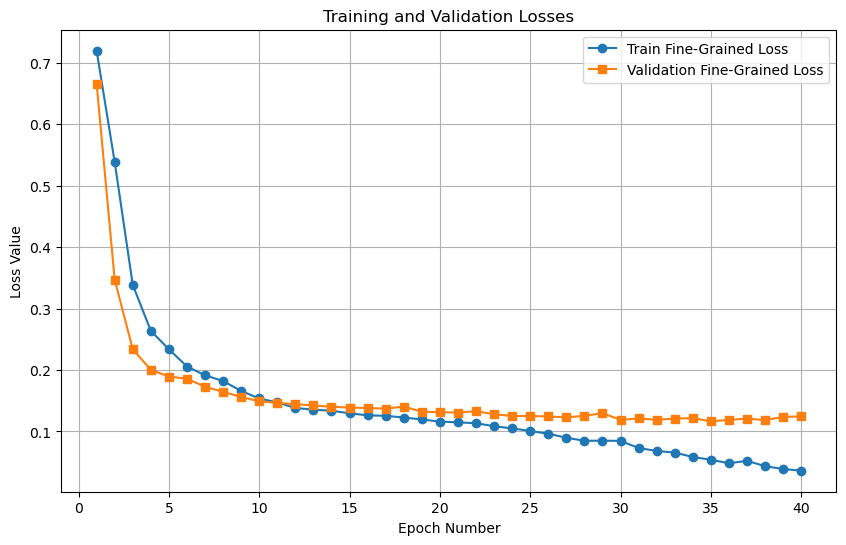

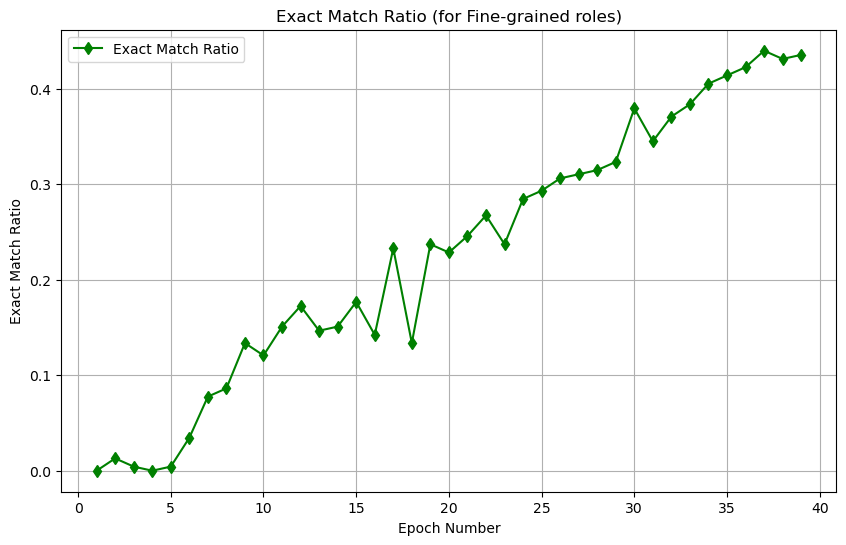

In [88]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_fine_losses)+1))  


# Plot train and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_fine_losses, label='Train Fine-Grained Loss', marker='o')
plt.plot(epochs, val_fine_losses, label='Validation Fine-Grained Loss', marker='s')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


# Plot Exact Match Ratios
plt.figure(figsize=(10, 6))
plt.plot(epochs[:-1], exact_match_ratios, label='Exact Match Ratio', marker='d', color='green')
plt.xlabel('Epoch Number')
plt.ylabel('Exact Match Ratio')
plt.title('Exact Match Ratio (for Fine-grained roles)')
plt.legend()
plt.grid(True)
plt.show()

## BERT Baseline

In [16]:
train_main_losses = []
train_fine_losses = []
val_main_losses = []
val_fine_losses = []
exact_match_ratios = []



# -----------------------------------------------------------
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased') # to test for the other multi-lingual model
print(f"Train dataset size: {len(df_train)}, Validation dataset size: {len(df_val)}")
train_dataset = RoleDataset(df_train, tokenizer)
val_dataset = RoleDataset(df_val, tokenizer)


#model = RoleClassifier(pretrained_model_name="xlm-roberta-base")
model = RoleClassifier(pretrained_model_name="bert-base-multilingual-cased")
model.bert.resize_token_embeddings(len(tokenizer)) #  resizing model embeddings after adding special tokens in tokenizer (<entity>,</entity>)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

model = train_model(model, train_loader, val_loader, epochs=100, lr=1e-5, device="cuda")
save_model(model)

Train dataset size: 927, Validation dataset size: 232
Epoch [1/100] - Main Loss: 0.3366, Fine Loss: 0.6898
Validation loss improved to 0.6035
  Validation Dataset : 
  Main Role Loss: 1.0216, Fine Role Loss: 0.6035
    Main Role Accuracy: 0.5043
    Main Role Precision (Macro): 0.1696
    Main Role Recall (Macro): 0.3333
    Main Role F1 (Macro): 0.2248
    Fine Grained Roles Metrics
      Macro Precision: 0.0074
      Macro Recall: 0.0895
      Macro F1: 0.0130
      Micro Precision: 0.0651
      Micro Recall: 0.1411
      Micro F1: 0.0891
      Exact Match Ratio: 0.0000
Epoch [2/100] - Main Loss: 0.3071, Fine Loss: 0.4480
Validation loss improved to 0.2631
  Validation Dataset : 
  Main Role Loss: 0.9709, Fine Role Loss: 0.2631
    Main Role Accuracy: 0.5172
    Main Role Precision (Macro): 0.5036
    Main Role Recall (Macro): 0.3546
    Main Role F1 (Macro): 0.2654
    Fine Grained Roles Metrics
      Macro Precision: 0.0000
      Macro Recall: 0.0000
      Macro F1: 0.0000
      Mi

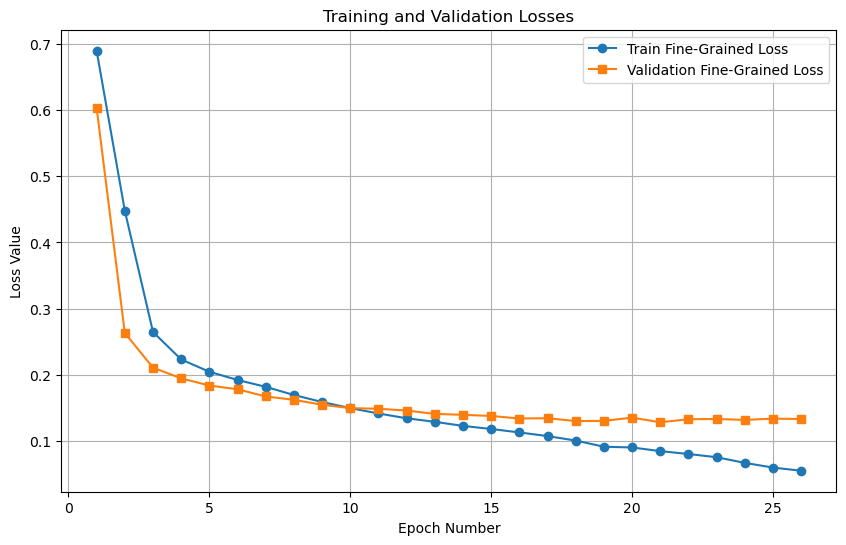

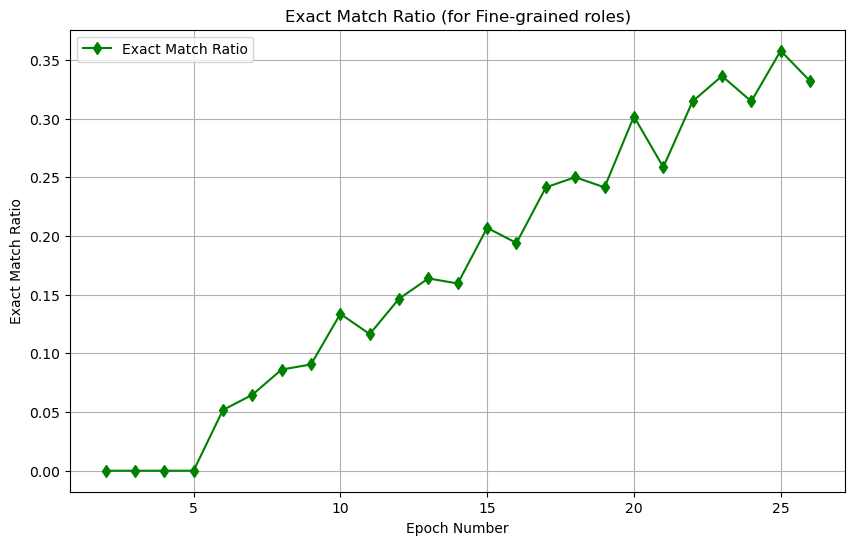

In [ ]:
epochs = list(range(1, len(train_fine_losses)+1))  


# Plot train and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_fine_losses, label='Train Fine-Grained Loss', marker='o')
plt.plot(epochs, val_fine_losses, label='Validation Fine-Grained Loss', marker='s')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


# Plot Exact Match Ratios
plt.figure(figsize=(10, 6))
plt.plot(epochs, exact_match_ratios, label='Exact Match Ratio', marker='d', color='green')
plt.xlabel('Epoch Number')
plt.ylabel('Exact Match Ratio')
plt.title('Exact Match Ratio (for Fine-grained roles)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Sample Prediction for <entity>China</entity> 
print("Sample Prediction :")
text = " over our country, and it was not shot down until it completed its trek across many states. In addition, Chinese investors are buying American farmland for nefarious reasons, and it was confirmed that China operated “police stations” in the United States to monitor their citizens in our country. <entity>China</entity> is constantly threatening Taiwan and its other neighbors while building up its military forces. Their proxy state, North Korea, has started regularly testing long-range ballistic missiles that concern their neighboring countries. Ukraine is in the third year of a bitter war with Russia. Last year,"
main_role, fine_roles = predict(model, tokenizer, text, device="cuda")
print(f"Predicted Main Role: {main_role}")
print(f"Predicted Fine-Grained Roles: {fine_roles}")

Sample Prediction :
Predicted Main Role: Antagonist
Predicted Fine-Grained Roles: ['Instigator']
